# GradCam
This notebook aims at applying GradCam algorithm on images in order to understand better what parts of an image influences the classification network. 
GradCam is supposed, via the last activation layer of the classification network, to highlight the parts of the image which led the classifier to give a label X for this image.
Source: [https://arxiv.org/pdf/1610.02391.pdf](https://arxiv.org/pdf/1610.02391.pdf)

In [1]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as Model
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from prepare_data import ConvertRgb, Rescale, RandomPad


# Chose model to use (type of Efficientnet, chose pth file)

In [34]:
EFFICIENTNETS = {
    'B0': 224, 'B1': 240,
    'B2': 288, 'B3': 300,
    'B4': 380, 'B5': 456,
    'B6': 528, 'B7': 600
    }

CLASSES = ['autre_epaule', 'autre_pistolet', 'epaule_a_levier_sous_garde',
        'epaule_a_percussion_silex', 'epaule_a_pompe', 'epaule_a_un_coup', 'epaule_a_verrou',
        'pistolet_a_percussion_silex', 'pistolet_semi_auto_moderne', 'revolver']

MODEL_NAME = 'B5'
MODEL_TORCH = Model.efficientnet_b5
INPUT_SIZE = EFFICIENTNETS[MODEL_NAME]

device = torch.device('cpu')

In [ ]:

def build_model(model: Model) -> Model:
    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model.classifier[1].in_features
    # to try later : add batch normalization and dropout
    model.classifier[1] = torch.nn.Linear(num_ftrs, len(CLASSES))
    model = model.to(device)
    return model


trained_model = build_model(MODEL_TORCH())
# Initialize model with the pretrained weights
trained_model.load_state_dict(
    torch.load('models/B5_2022-02-09_13/B5_2022-02-09_13.pth', map_location=device)['model_state_dict']
)

In [95]:
%%capture
class EfficientNet(nn.Module):
    def __init__(self, model):
        super(EfficientNet, self).__init__()
        
        # get the pretrained VGG19 network
        self.net = model
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.net.features
        
        # get the last pool of the features stem
        self.pool = self.net.avgpool
        
        # get the classifier of the vgg19
        self.classifier = self.net.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

model = EfficientNet(trained_model)
model.eval()

In [103]:
def gradcam_heatmap(in_tensor, pred_index):
    preds = model(in_tensor)
    
    if pred_index is None:
        pred_index = preds.argmax(dim=1)
    else:
        assert pred_index < len(CLASSES)
    print(f"GradCam for class {CLASSES[pred_index]}, ranked {1+list(torch.argsort(preds, dim=1, descending=True)[0]).index(pred_index)}/{len(CLASSES)}")
        
    # get the gradient of the output with respect to the parameters of the model
    preds[:, 3].backward()

    # pull the gradients out of the model
    gradients = model.get_activations_gradient()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # get the activations of the last convolutional layer
    activations = model.get_activations(in_tensor).detach()

    # weight the channels by corresponding gradients
    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    return np.uint8(255 * heatmap.numpy())

In [104]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

loader =  transforms.Compose([
            ConvertRgb(),
            Rescale(456),
            RandomPad(456),
            transforms.ToTensor(),
            transforms.Normalize(mean= mean, std= std)
        ])

def load_efficientnet_image(path):
    im = Image.open(path)
    image = loader(im).float()
    image = image.unsqueeze(0)
    return image

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

def get_image_from_efficientnet_tensor(in_tensor):
    inv_tensor = inv_normalize(in_tensor)
    img = inv_tensor.squeeze(0).permute(1,2,0)
    return np.uint8(255 * img.numpy())

# Chose input image

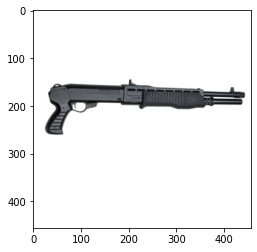

In [175]:
in_tensor = load_efficientnet_image('test/spas12.jpg')

img = get_image_from_efficientnet_tensor(in_tensor)
plt.imshow(img)

# Compute gradcam
Paramètres:
- tenseur d'entrée (image chargée dans la cell précédente)
- index de la classe de l'on veut tester (entre 0 et 9). Si None, prendra l'index de la classe qui a le plus haut score de prédiction.

La fonction GradCam écrit un message avec les infos suivantes:
- rappel de la classe choisie pour tester
- pour l'image passée en entrée, quel était le rang de cette classe parmi toutes les prédictions (1=classe la plus probable, 10=classe la moins probable)

GradCam for class autre_pistolet, ranked 1/10


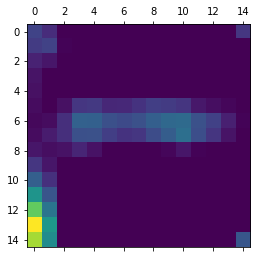

In [176]:
heatmap = gradcam_heatmap(in_tensor, None)
# draw the heatmap
plt.matshow(heatmap)

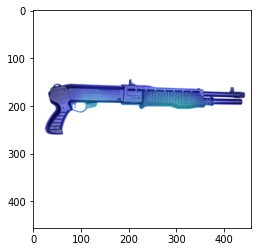

In [177]:
def show_heatmap_on_image(heatmap, img):
    import cv2
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)[:,:,::-1] # cv2 is in BGR instead of RGB
    superimposed_img = np.uint8(np.clip(heatmap * 0.4 + img, 0, 255))
    plt.imshow(superimposed_img)

show_heatmap_on_image(heatmap, img)